In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
zip_file_path = '/content/drive/My Drive/Colab Notebooks/CreatorsLab/osteo_arthritis/osteoarthritis.zip'
output_path = '/content/drive/My Drive/Colab Notebooks/CreatorsLab/osteo_arthritis/'
!unzip -q "$zip_file_path" -d "$output_path"

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import shutil
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.applications.efficientnet import EfficientNetB5
import time

In [20]:
train_path = '/content/drive/My Drive/Colab Notebooks/CreatorsLab/osteo_arthritis/train/'
test_path = '/content/drive/My Drive/Colab Notebooks/CreatorsLab/osteo_arthritis/test/'
val_path = '/content/drive/My Drive/Colab Notebooks/CreatorsLab/osteo_arthritis/val/'

In [45]:
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20
)
t_and_v_gen = ImageDataGenerator()

In [46]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

valid_generator = t_and_v_gen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [47]:
length = len(test_generator)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

In [48]:
K.clear_session()
tf.compat.v1.reset_default_graph()

In [49]:
img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB5'
base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
base_model.trainable = True

In [50]:
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [51]:
lr = 0.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [53]:
epochs = 40
history = model.fit(
    train_generator,
    steps_per_epoch=47,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=None,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/40
47/47 [==============================] - 156s 1s/step - loss: 9.7610 - accuracy: 0.3245 - val_loss: 8.9598 - val_accuracy: 0.4431
Epoch 2/40
47/47 [==============================] - 51s 1s/step - loss: 8.3706 - accuracy: 0.4162 - val_loss: 7.6183 - val_accuracy: 0.4443
Epoch 3/40
47/47 [==============================] - 56s 1s/step - loss: 7.5533 - accuracy: 0.4688 - val_loss: 6.9847 - val_accuracy: 0.4249
Epoch 4/40
47/47 [==============================] - 50s 1s/step - loss: 6.8620 - accuracy: 0.5286 - val_loss: 6.2703 - val_accuracy: 0.5726
Epoch 5/40
47/47 [==============================] - 56s 1s/step - loss: 6.2786 - accuracy: 0.5539 - val_loss: 5.8390 - val_accuracy: 0.5787
Epoch 6/40
47/47 [==============================] - 52s 1s/step - loss: 5.7966 - accuracy: 0.5791 - val_loss: 5.4600 - val_accuracy: 0.5860
Epoch 7/40
47/47 [==============================] - 51s 1s/step - loss: 5.3799 - accuracy: 0.5964 - val_loss: 5.0671 - val_accuracy: 0.6029
Epoch 8/40
47/47 [=

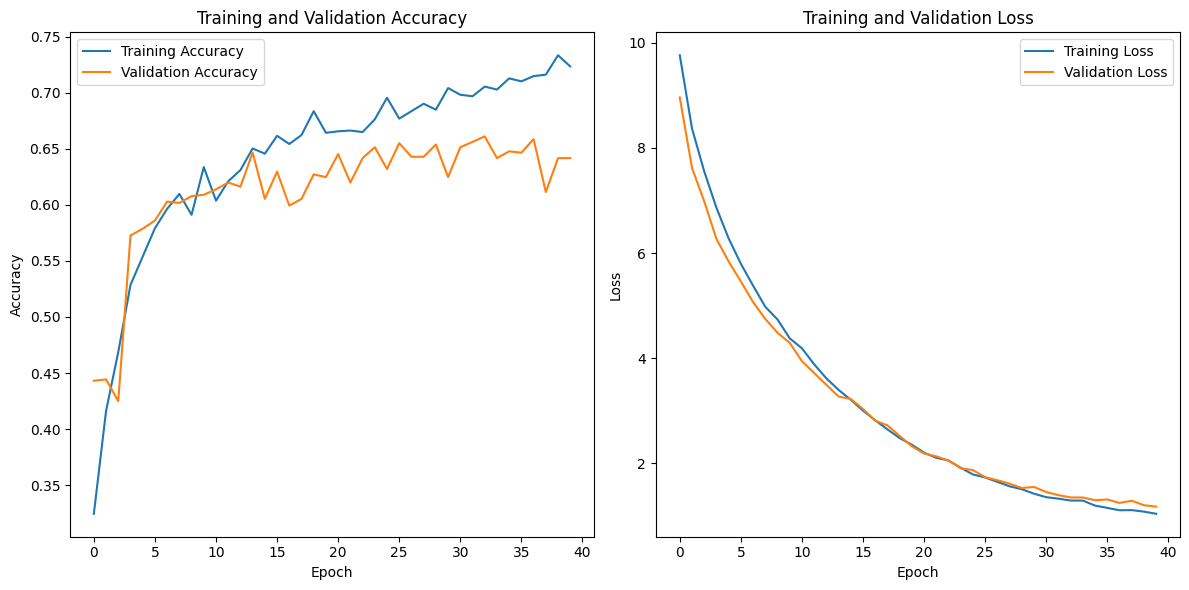

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()